# Análisis Exploratorio de Datos (EDA)

**Proyecto:** Pipeline MLOps - Predicción de Pago a Tiempo de Créditos

Este notebook realiza el análisis exploratorio del dataset cargado, combinando una caracterización inicial con un análisis estadístico profundo.

## 1. Descripción general de los datos
- Caracterización de los datos: categóricos, numéricos, ordinales, nominales, dicotómicos, politómicos.
- Revisión de nulos y unificación de su representación.

In [30]:
# Importación de librerías y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2 & 3. Carga, Unificación y Exploración Inicial
Cargamos los datos, unificamos nulos y eliminamos variables irrelevantes.

In [31]:
# Cargar datos
try:
    df = pd.read_excel('../../Base_de_datos.xlsx')
    print("✓ Datos cargados desde ruta relativa principal")
except FileNotFoundError:
    try:
        df = pd.read_excel('Base_de_datos.xlsx')
        print("✓ Datos cargados desde directorio actual")
    except FileNotFoundError:
        print("❌ No se encontró el archivo. Verifique la ruta.")

df_original = df.copy()
print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
df.head()

✓ Datos cargados desde ruta relativa principal
Dimensiones: 10,763 filas x 23 columnas


,tipo_credito,fecha_prestamo,capital_prestado,plazo_meses,edad_cliente,tipo_laboral,salario_cliente,total_otros_prestamos,cuota_pactada,puntaje,puntaje_datacredito,cant_creditosvigentes,huella_consulta,saldo_mora,saldo_total,saldo_principal,saldo_mora_codeudor,creditos_sectorFinanciero,creditos_sectorCooperativo,creditos_sectorReal,promedio_ingresos_datacredito,tendencia_ingresos,Pago_atiempo
0,7,2024-12-21 11:31:35,3692160.000,10,42,Independiente,8000000,2500000,341296,88.768,695.000,10,5,0.000,51258.000,51258.000,0.000,5,0,0,908526.000,Estable,1
1,4,2025-04-22 09:47:35,840000.000,6,60,Empleado,3000000,2000000,124876,95.228,789.000,3,1,0.000,8673.000,8673.000,0.000,0,0,2,939017.000,Creciente,1
2,9,2026-01-08 12:22:40,5974028.400,10,36,Independiente,4036000,829000,529554,47.614,740.000,4,5,0.000,18702.000,18702.000,0.000,3,0,0,NaN,NaN,0
3,4,2025-08-04 12:04:10,1671240.000,6,48,Empleado,1524547,498000,252420,95.228,837.000,4,4,0.000,15782.000,15782.000,0.000,3,0,0,1536193.000,Creciente,1
4,9,2025-04-26 11:24:26,2781636.000,11,44,Empleado,5000000,4000000,217037,95.228,771.000,4,6,0.000,204804.000,204804.000,0.000,3,0,1,933473.000,Creciente,1


## 4. Información general y estadística descriptiva
Revisión general y estadística descriptiva enriquecida (skewness, kurtosis).

In [32]:
print("INFORMACIÓN GENERAL:")
df.info()

print("\nESTADÍSTICA DESCRIPTIVA (Numéricas):")
display(df.describe().T)

# Identificar tipos de variables
col_num = df.select_dtypes(include=['number']).columns.tolist()
col_cat = df.select_dtypes(include=['object', 'category']).columns.tolist()
col_date = [c for c in df.columns if 'fecha' in c.lower()]

print(f"\nNuméricas: {len(col_num)} | Categóricas: {len(col_cat)} | Fechas: {len(col_date)}")

INFORMACIÓN GENERAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tipo_credito                   10763 non-null  int64         
 1   fecha_prestamo                 10763 non-null  datetime64[ns]
 2   capital_prestado               10763 non-null  float64       
 3   plazo_meses                    10763 non-null  int64         
 4   edad_cliente                   10763 non-null  int64         
 5   tipo_laboral                   10763 non-null  object        
 6   salario_cliente                10763 non-null  int64         
 7   total_otros_prestamos          10763 non-null  int64         
 8   cuota_pactada                  10763 non-null  int64         
 9   puntaje                        10763 non-null  float64       
 10  puntaje_datacredito            10757 non-null  float64       

,count,mean,min,25%,50%,75%,max,std
tipo_credito,10763.000,5.411,4.000,4.000,4.000,9.000,68.000,2.338
fecha_prestamo,10763,2025-04-16 23:06:02.111121664,2024-11-26 09:17:04,2025-01-20 17:33:07.500000,2025-03-27 16:23:12,2025-06-16 13:27:58,2026-04-26 18:43:52,NaN
capital_prestado,10763.000,2434315.001,360000.000,1224831.000,1921920.000,3084840.000,41444152.800,1909642.759
plazo_meses,10763.000,10.576,2.000,6.000,10.000,12.000,90.000,6.632
edad_cliente,10763.000,43.949,19.000,33.000,42.000,53.000,123.000,15.061
salario_cliente,10763.000,17216431.460,0.000,2000000.000,3000000.000,4875808.000,22000000000.000,355476717.603
total_otros_prestamos,10763.000,6238869.649,0.000,500000.000,1000000.000,2000000.000,6787675263.000,118418316.941
cuota_pactada,10763.000,243617.407,23944.000,121041.500,182863.000,287833.500,3816752.000,210493.695
puntaje,10763.000,91.170,-38.010,95.228,95.228,95.228,95.228,16.465
puntaje_datacredito,10757.000,780.791,-7.000,757.000,791.000,825.000,999.000,104.878



Numéricas: 20 | Categóricas: 2 | Fechas: 1


## 5. Revisión y tratamiento de valores nulos
Análisis detallado de valores nulos y su impacto.

COLUMNAS CON VALORES NULOS:
                               Nulos  Porcentaje
tendencia_ingresos              2932      27.241
promedio_ingresos_datacredito   2930      27.223
saldo_mora_codeudor              590       5.482
saldo_principal                  405       3.763
saldo_total                      156       1.449
saldo_mora                       156       1.449
puntaje_datacredito                6       0.056


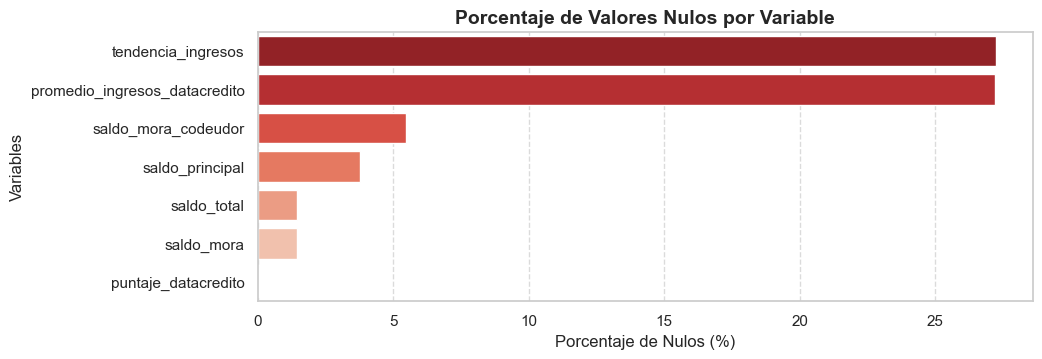

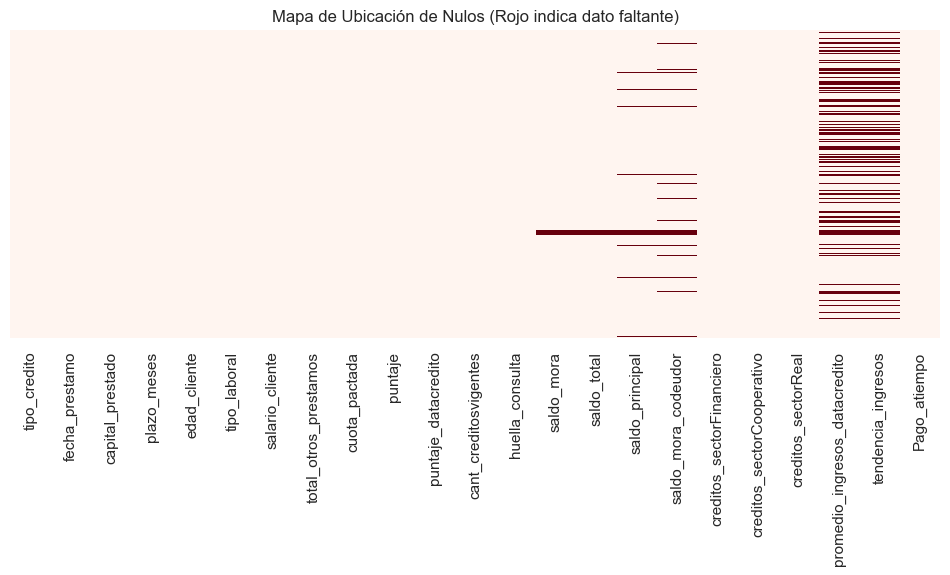

In [33]:
# Unificar nulos
nulos_list = ['NA', 'N/A', '', 'null', 'None', 'nan', '?', '-']
df.replace(nulos_list, np.nan, inplace=True)

# Análisis detallado de conteo
null_counts = df.isnull().sum()
null_pct = (df.isnull().sum() / len(df)) * 100
null_df = pd.DataFrame({'Nulos': null_counts, 'Porcentaje': null_pct}).sort_values('Porcentaje', ascending=False)
null_df_filtered = null_df[null_df['Nulos'] > 0]

print("COLUMNAS CON VALORES NULOS:")
print(null_df_filtered)

# 1. Gráfico de Barras (Más claro para ver porcentajes exactos)
plt.figure(figsize=(10, len(null_df_filtered) * 0.5 if len(null_df_filtered) > 5 else 6))
sns.barplot(x=null_df_filtered['Porcentaje'], y=null_df_filtered.index, palette='Reds_r')
plt.title('Porcentaje de Valores Nulos por Variable', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje de Nulos (%)')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 2. Mapa de Calor (Visión general de distribución)
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='Reds')
plt.title('Mapa de Ubicación de Nulos (Rojo indica dato faltante)', fontsize=12)
plt.show()

## 6. Análisis Univariable (Categóricas y Numéricas)
Distribución detallada de las variables.

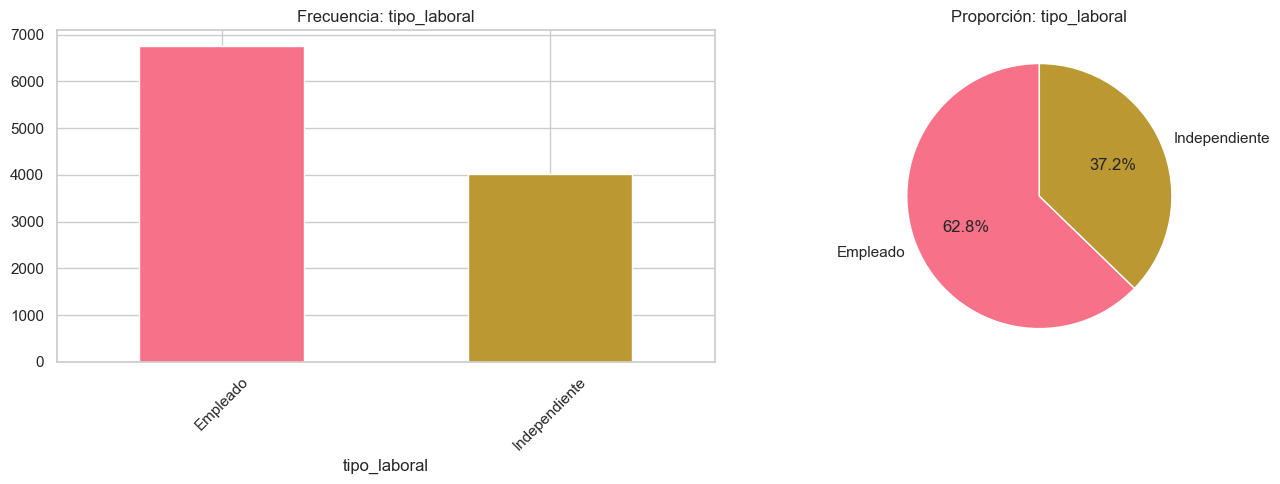

In [34]:
# Categóricas
for col in col_cat:
    if df[col].nunique() > 20: continue # Skip high cardinality
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar Plot
    count_data = df[col].value_counts()
    count_data.plot(kind='bar', ax=ax[0], color=sns.color_palette('husl'))
    ax[0].set_title(f'Frecuencia: {col}')
    ax[0].tick_params(axis='x', rotation=45)
    
    # Pie Chart
    ax[1].pie(count_data, labels=count_data.index, autopct='%1.1f%%', startangle=90)
    ax[1].set_title(f'Proporción: {col}')
    plt.tight_layout()
    plt.show()

## 7. Visualización Numérica y Detección de Outliers
Histogramas y Boxplots para entender la distribución y detectar anomalías.

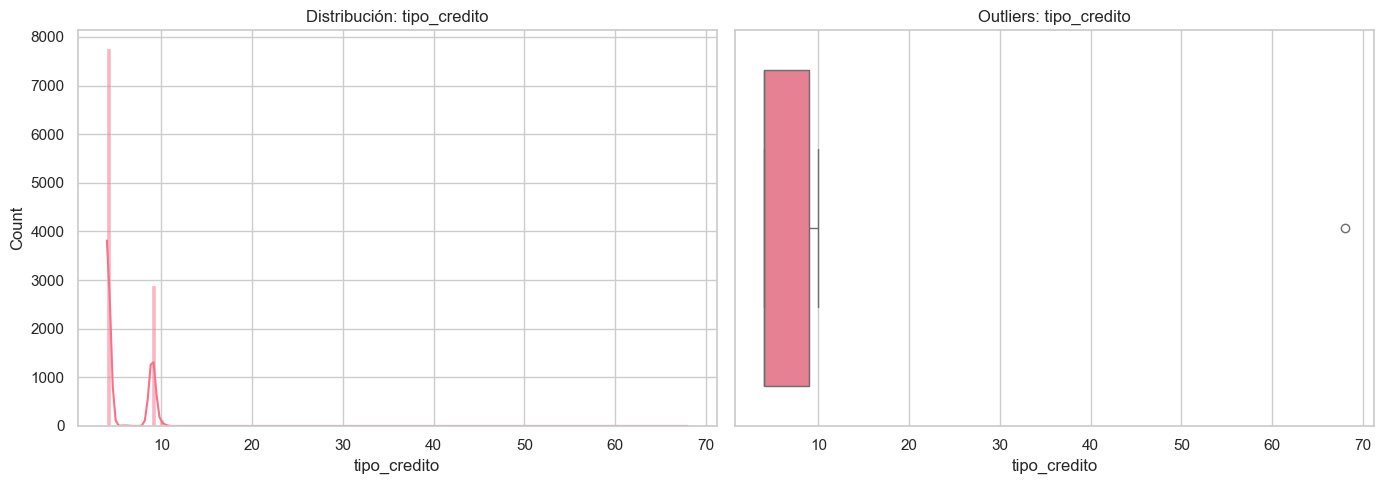

⚠️ tipo_credito: 1 outliers detectados (0.0%)


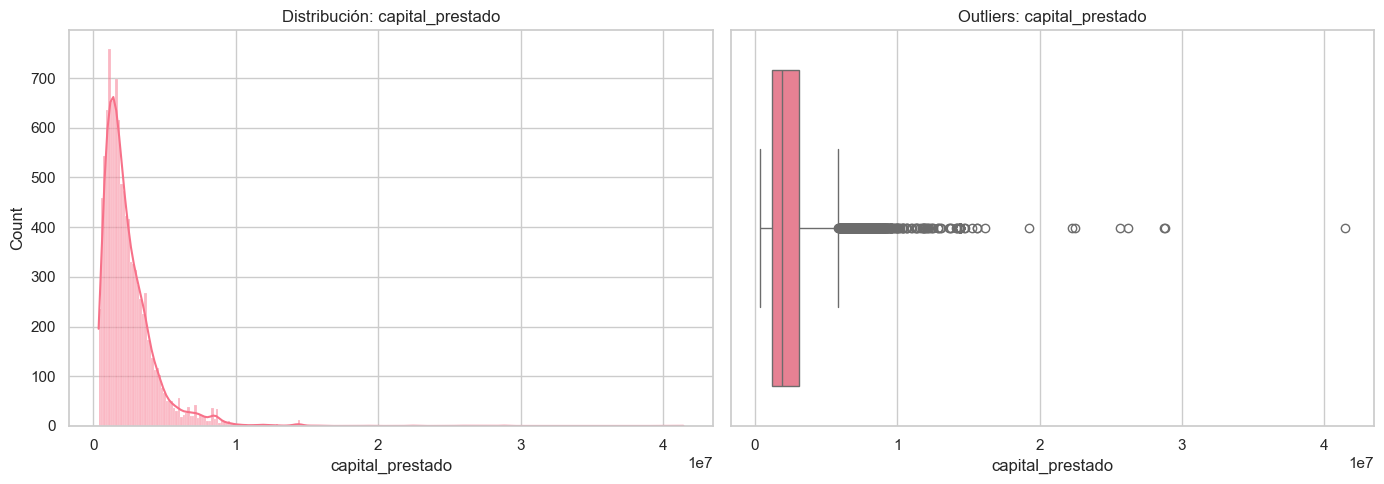

⚠️ capital_prestado: 550 outliers detectados (5.1%)


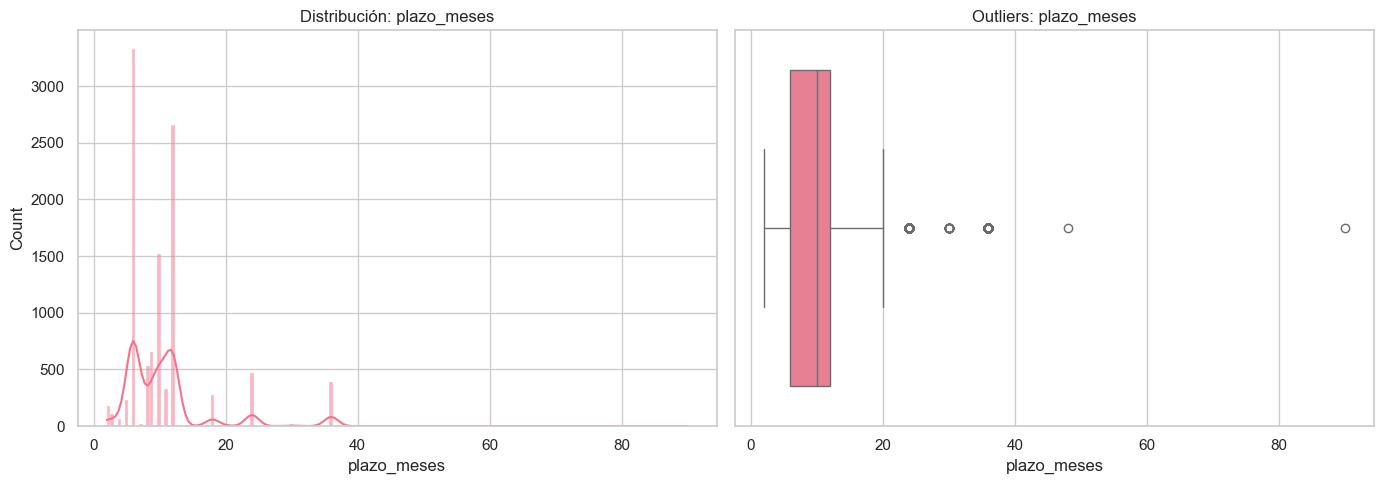

⚠️ plazo_meses: 869 outliers detectados (8.1%)


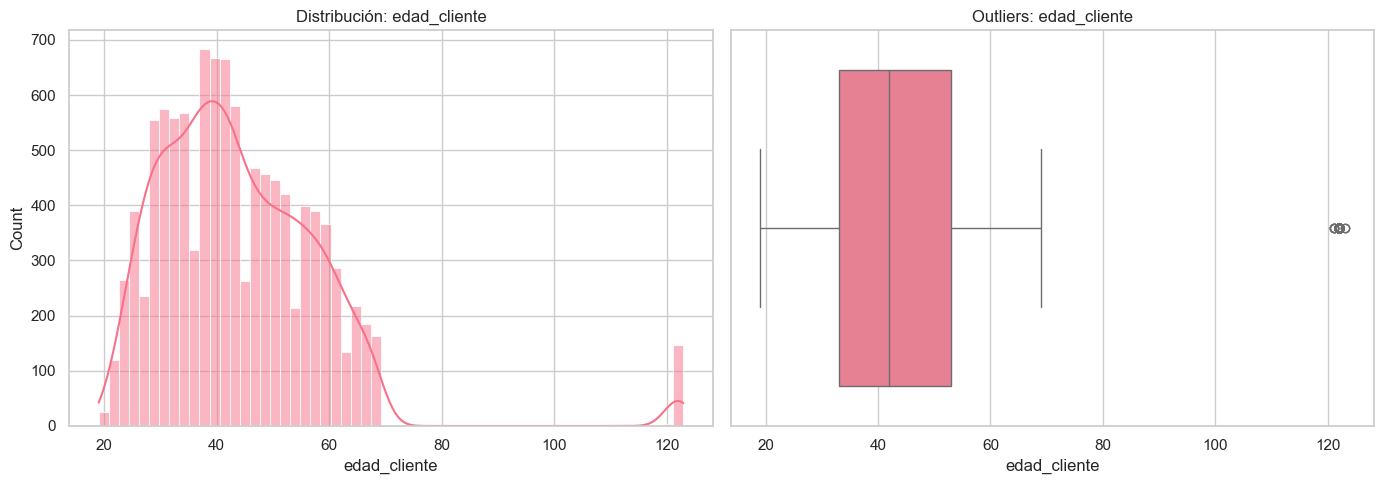

⚠️ edad_cliente: 150 outliers detectados (1.4%)


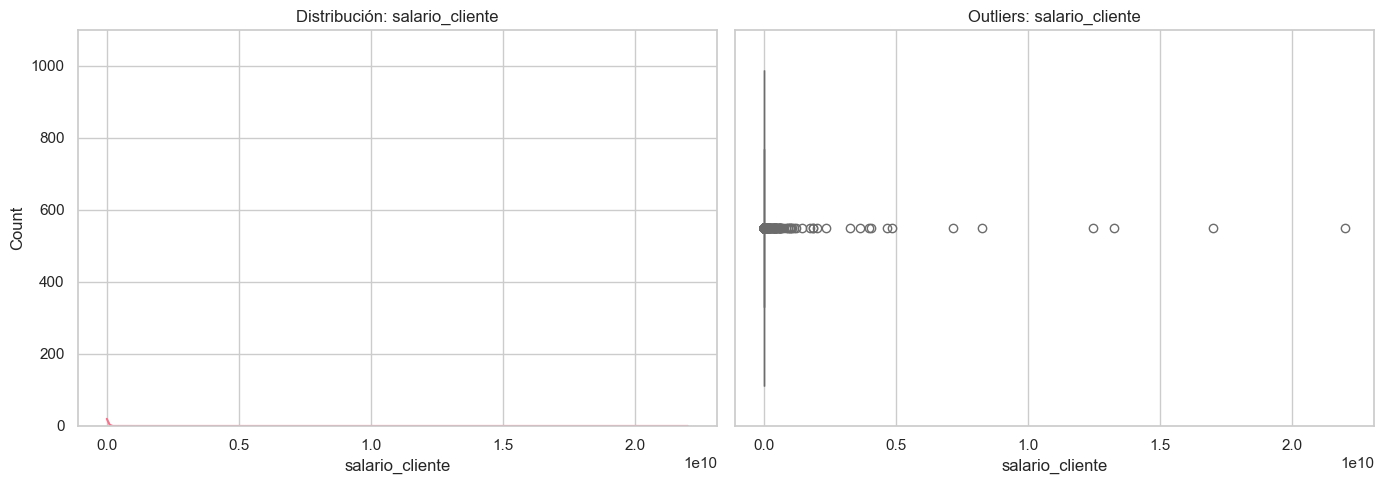

⚠️ salario_cliente: 718 outliers detectados (6.7%)


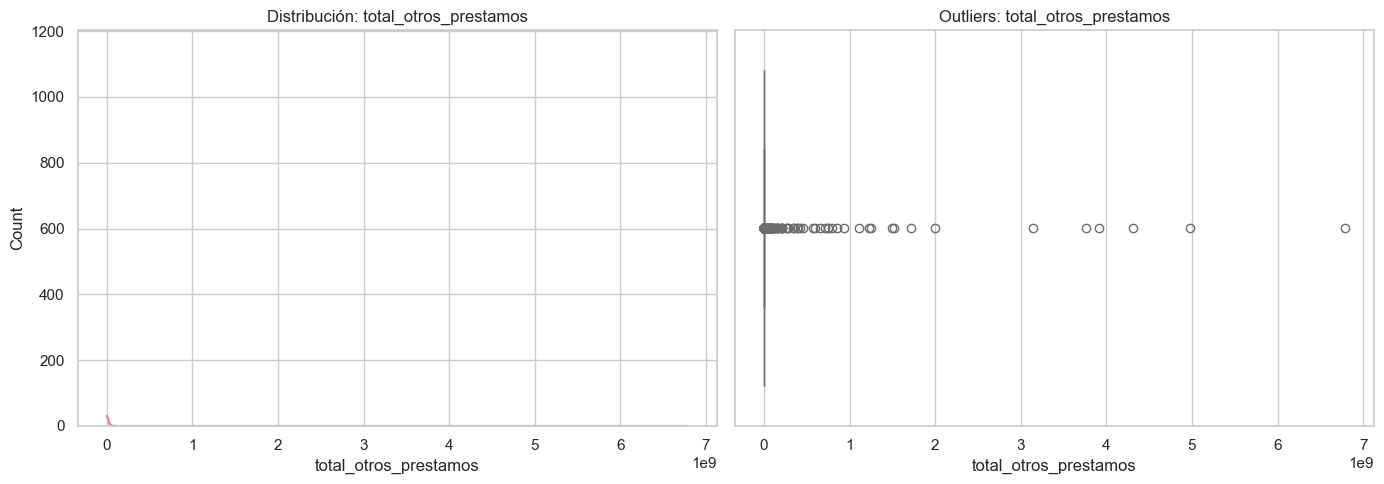

⚠️ total_otros_prestamos: 589 outliers detectados (5.5%)


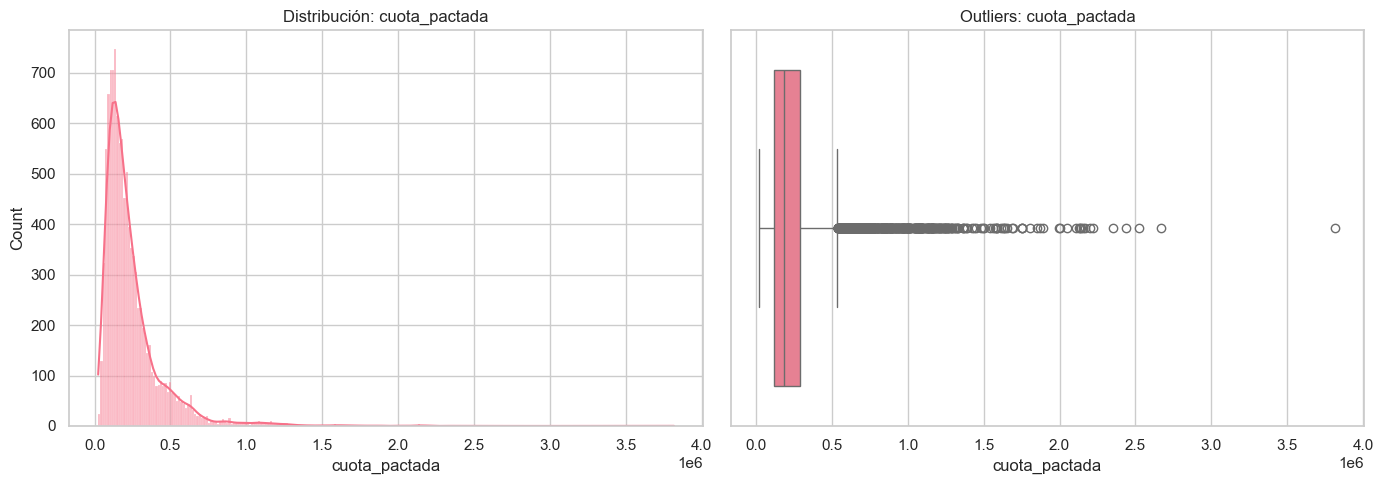

⚠️ cuota_pactada: 765 outliers detectados (7.1%)


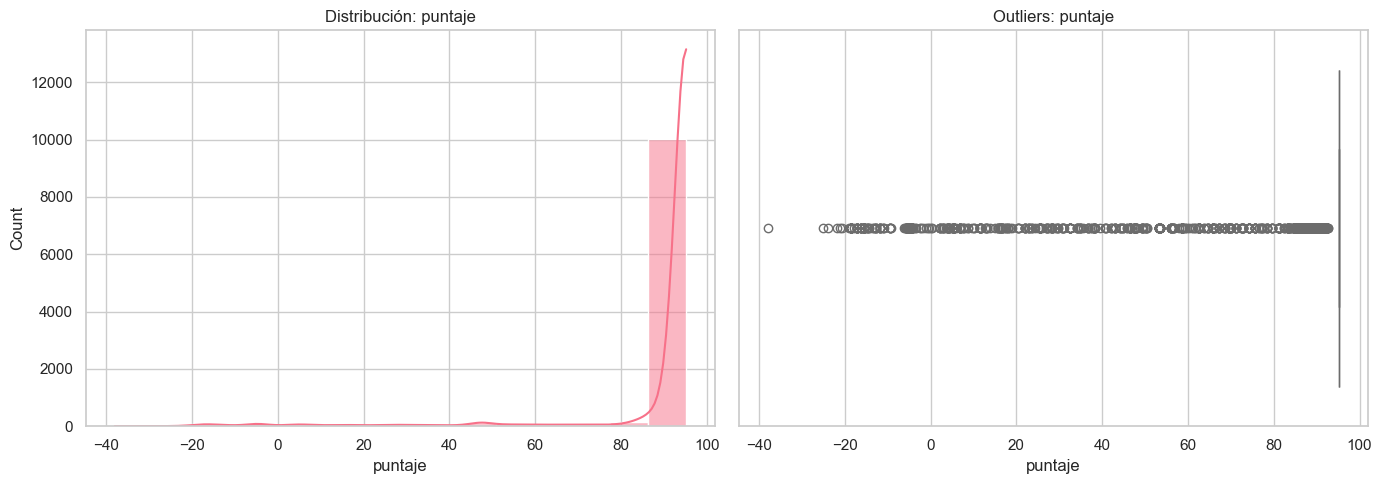

⚠️ puntaje: 1356 outliers detectados (12.6%)


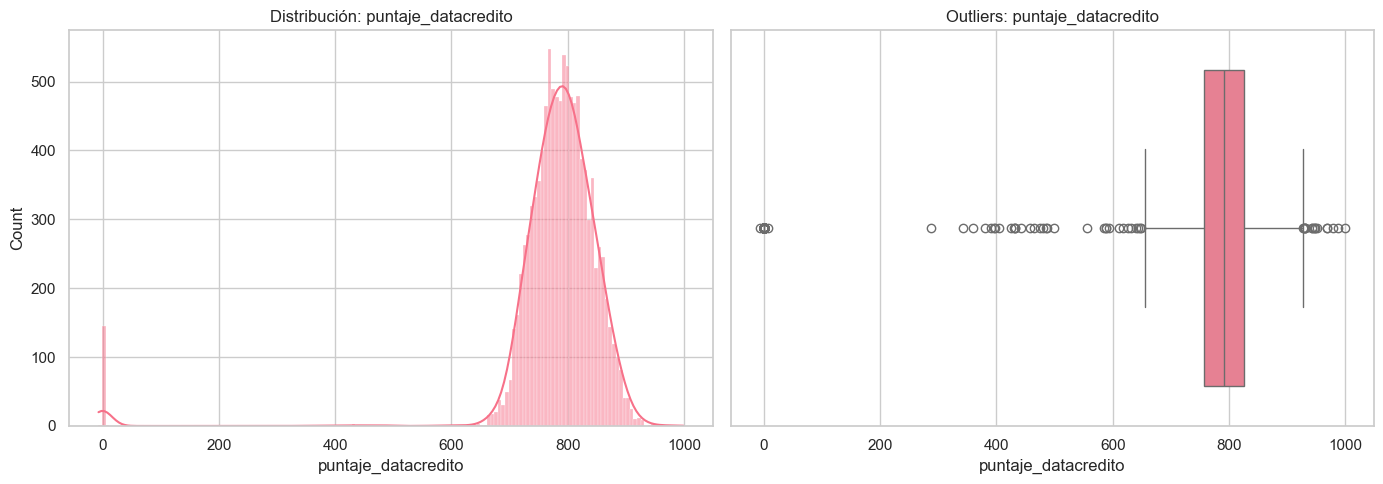

⚠️ puntaje_datacredito: 196 outliers detectados (1.8%)


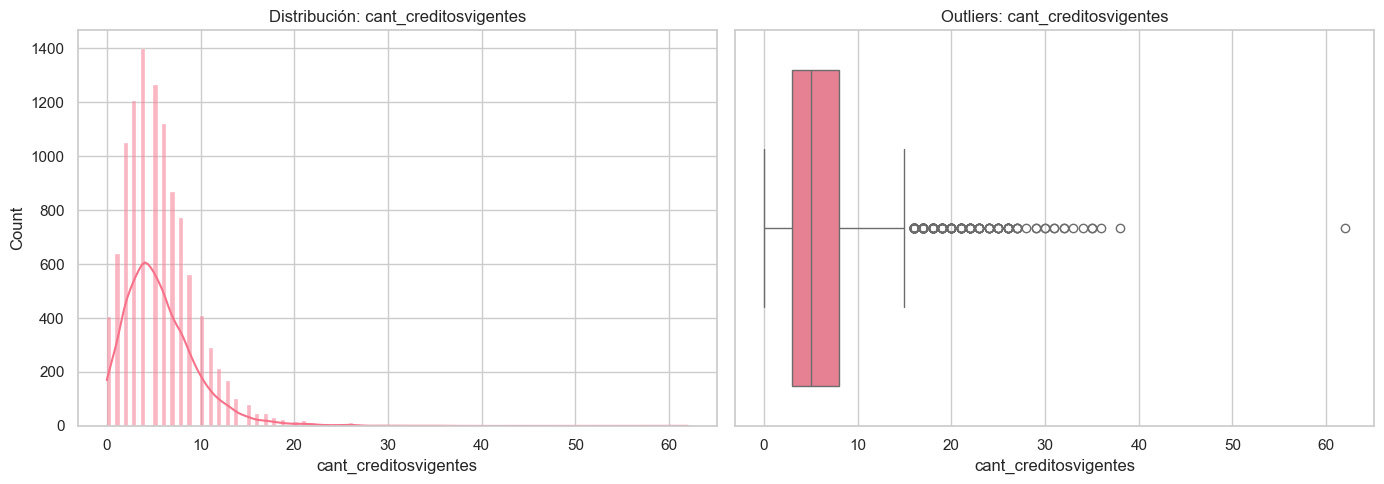

⚠️ cant_creditosvigentes: 242 outliers detectados (2.2%)


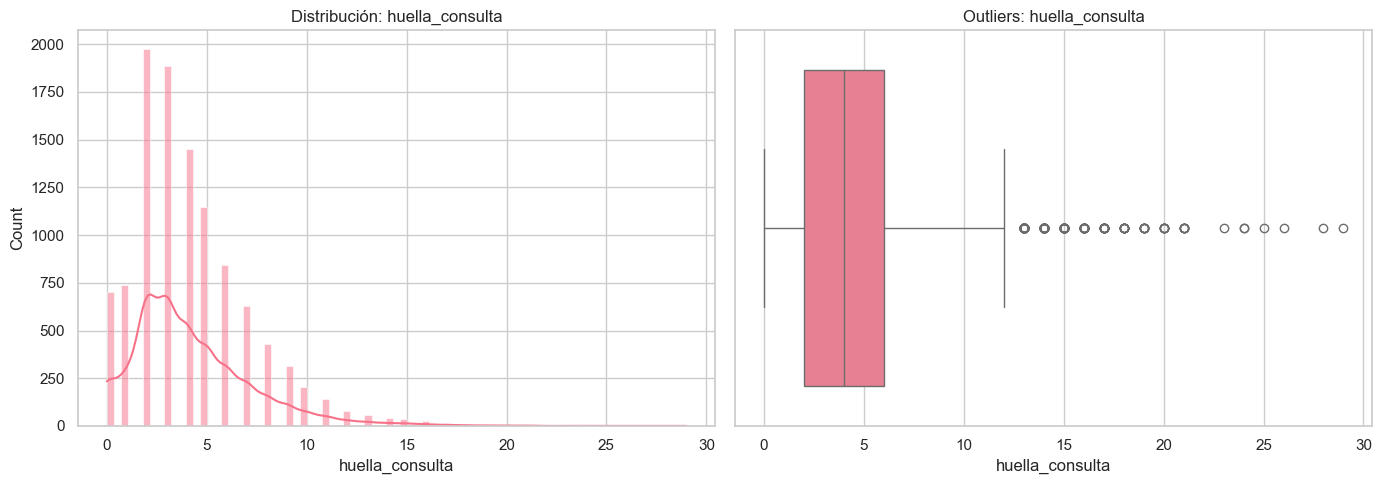

⚠️ huella_consulta: 216 outliers detectados (2.0%)


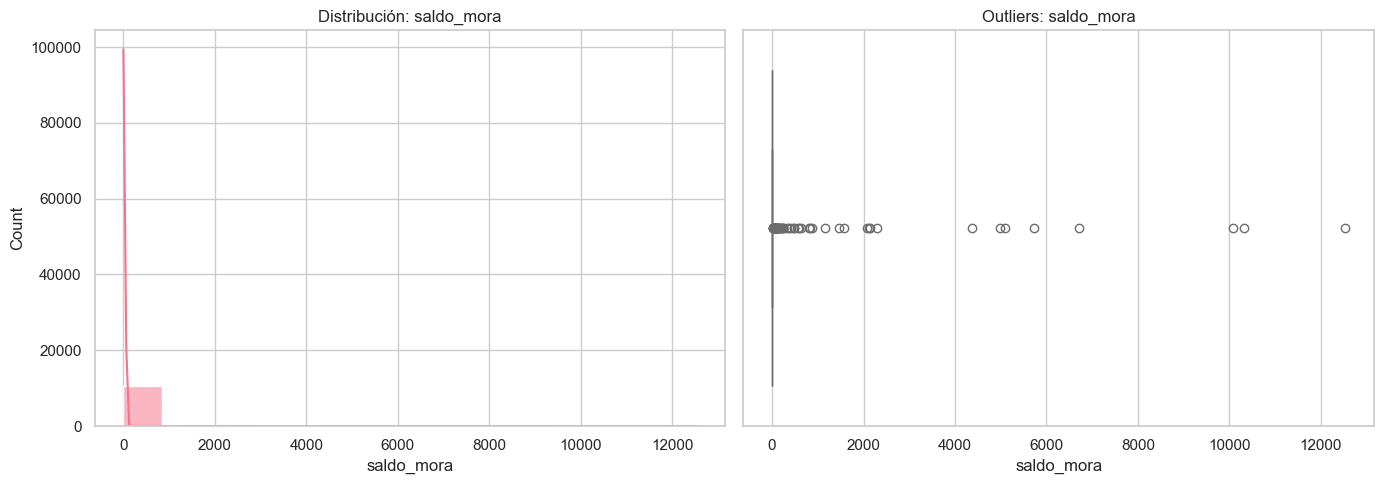

⚠️ saldo_mora: 55 outliers detectados (0.5%)


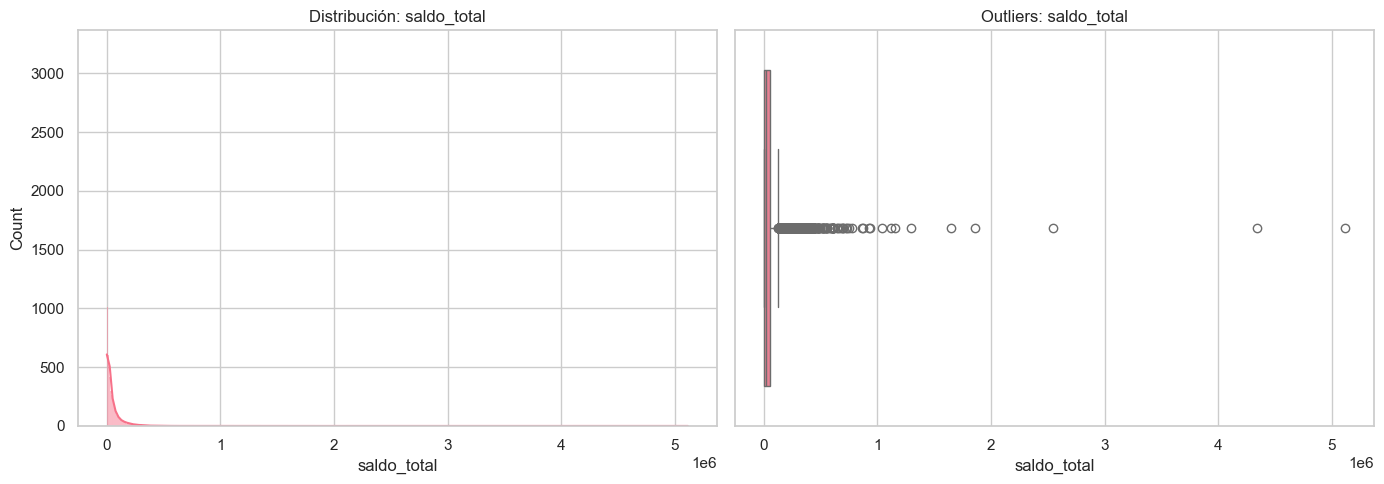

⚠️ saldo_total: 970 outliers detectados (9.0%)


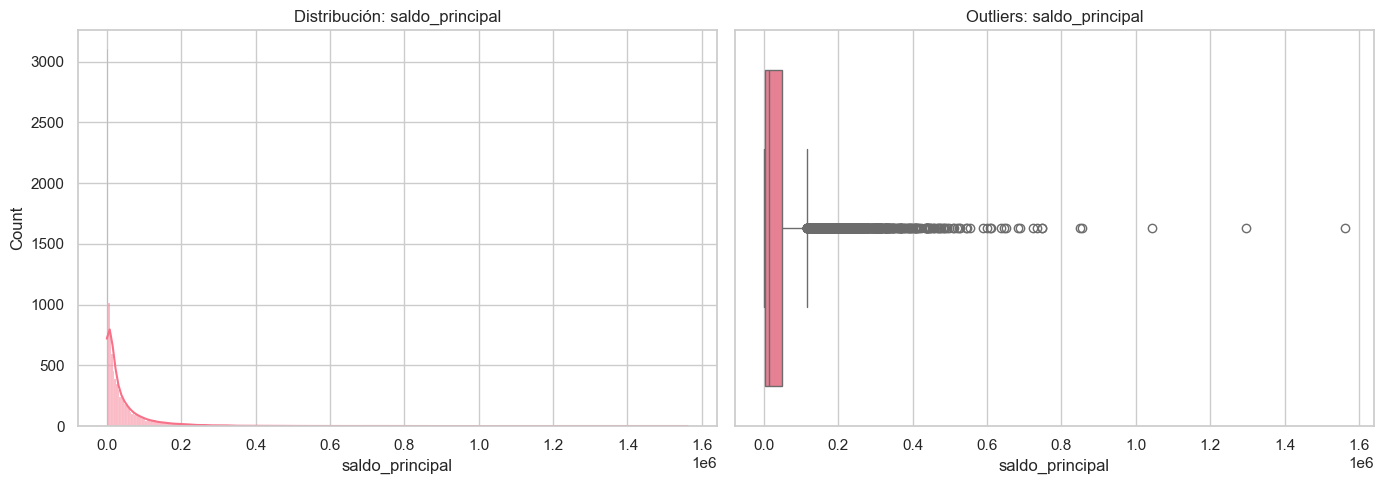

⚠️ saldo_principal: 951 outliers detectados (8.8%)


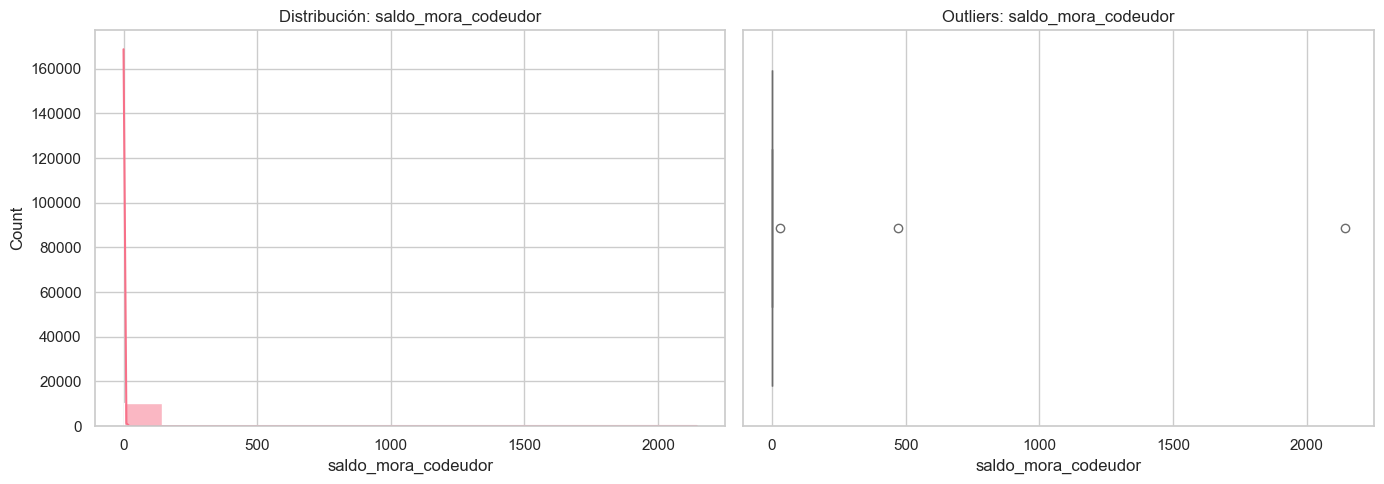

⚠️ saldo_mora_codeudor: 3 outliers detectados (0.0%)


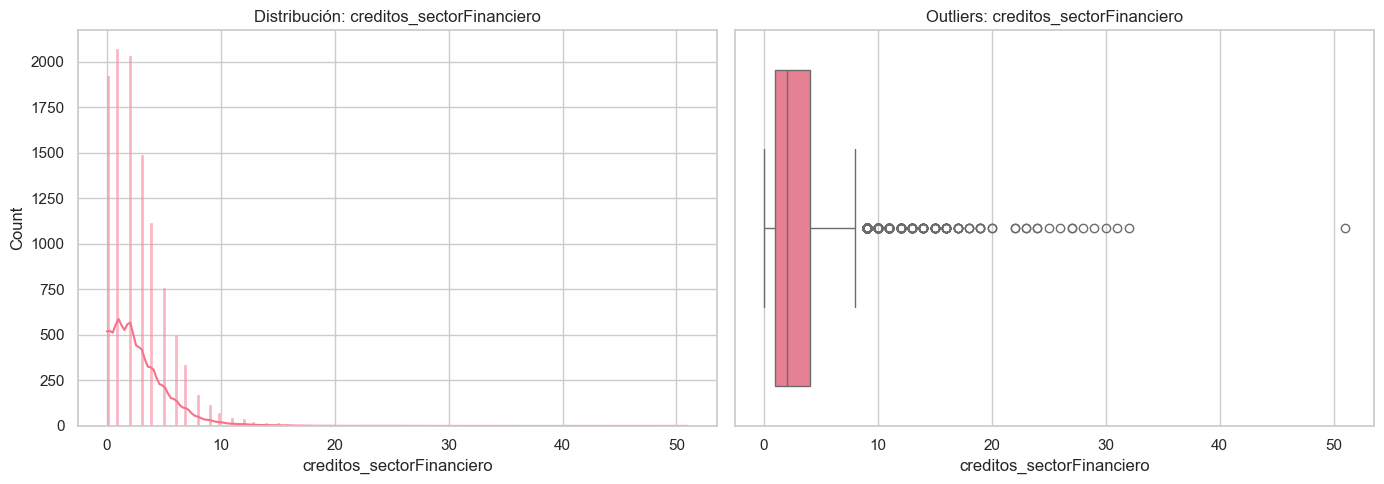

⚠️ creditos_sectorFinanciero: 364 outliers detectados (3.4%)


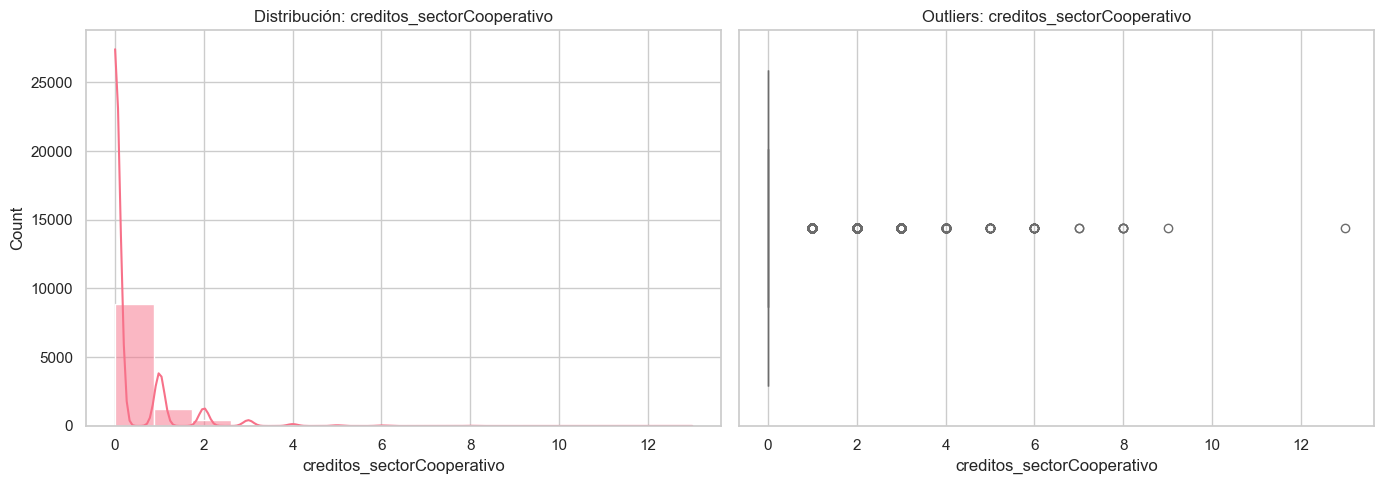

⚠️ creditos_sectorCooperativo: 1895 outliers detectados (17.6%)


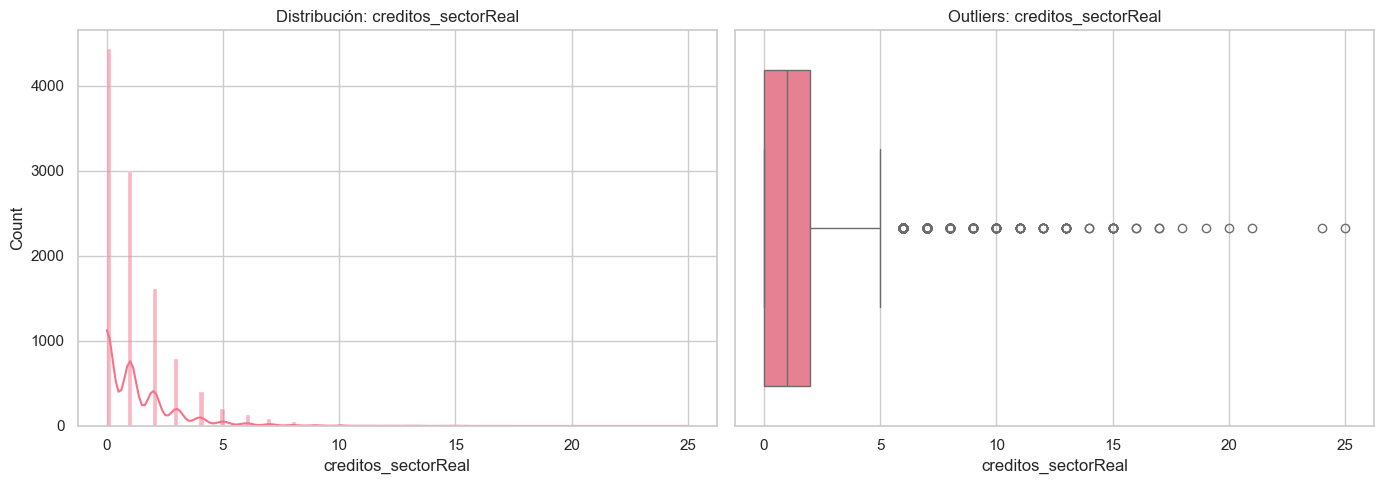

⚠️ creditos_sectorReal: 350 outliers detectados (3.3%)


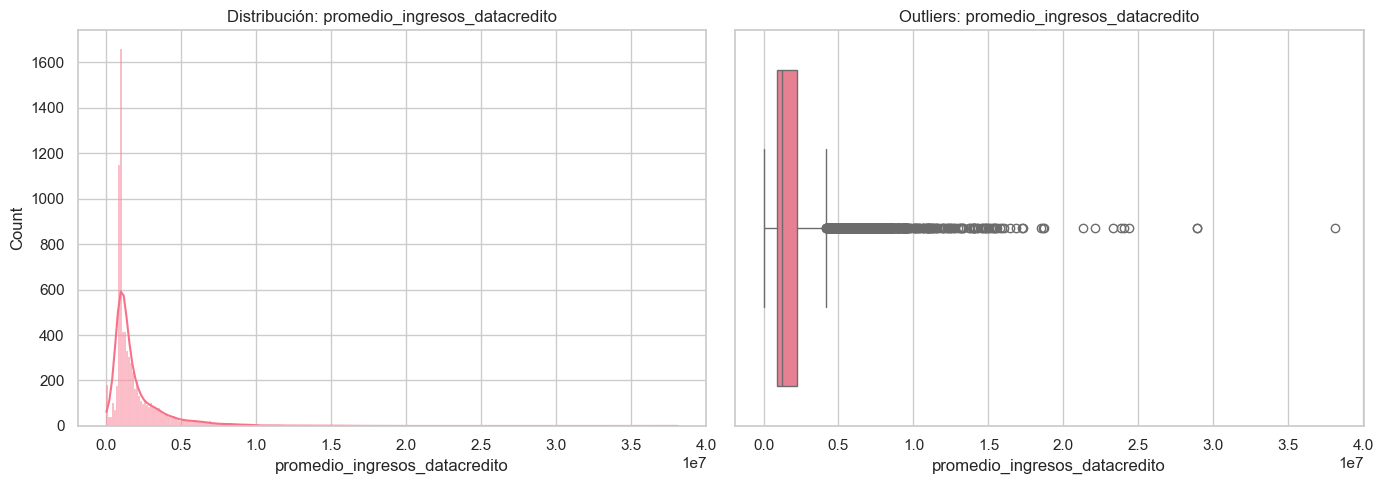

⚠️ promedio_ingresos_datacredito: 784 outliers detectados (7.3%)


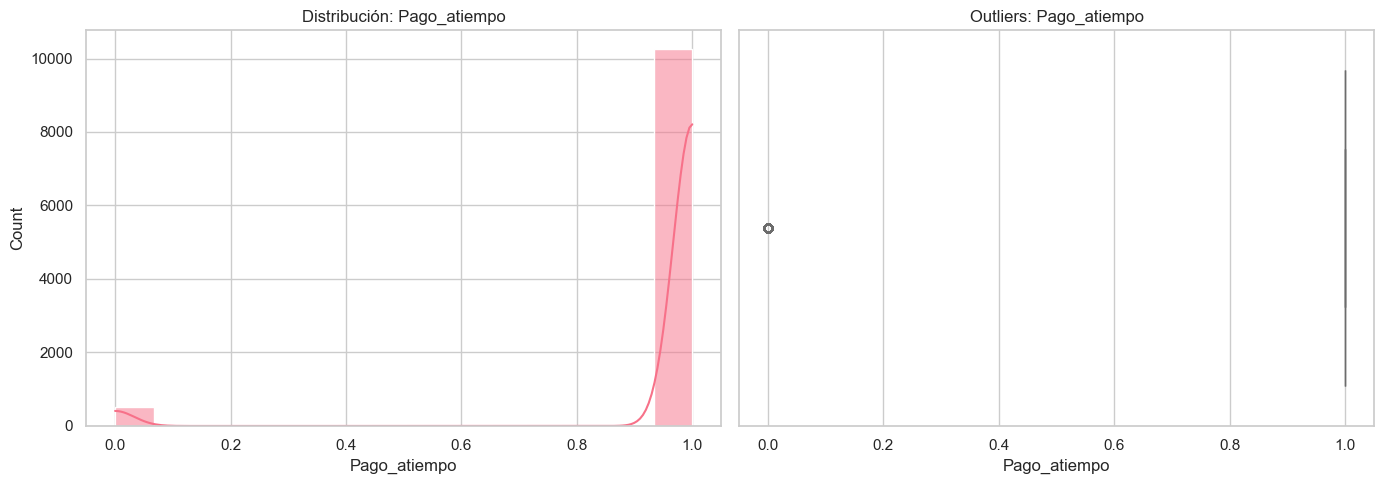

⚠️ Pago_atiempo: 511 outliers detectados (4.7%)


In [35]:
# Numéricas & Outliers
for col in col_num:
    if 'id' in col.lower(): continue
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograma con KDE
    sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f'Distribución: {col}')
    
    # Boxplot
    sns.boxplot(x=df[col].dropna(), ax=axes[1])
    axes[1].set_title(f'Outliers: {col}')
    
    plt.tight_layout()
    plt.show()
    
    # IQR Outlier Detection
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    if len(outliers) > 0:
        print(f"⚠️ {col}: {len(outliers)} outliers detectados ({len(outliers)/len(df)*100:.1f}%)")

## 8. Análisis Avanzado (Bivariable y Multivariable)
Relaciones entre variables y la variable objetivo `Pago_atiempo`.

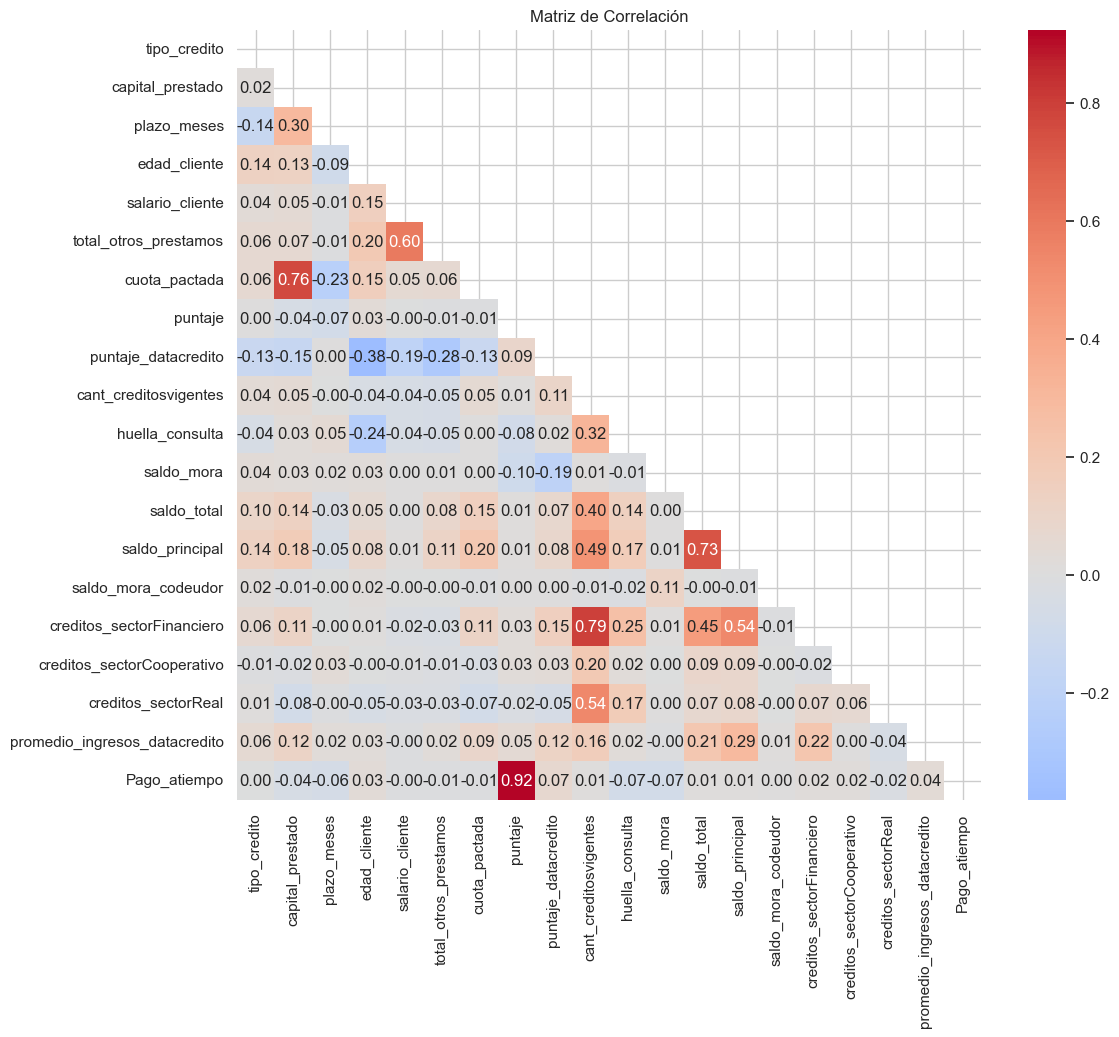

CORRELACIÓN CON PAGO_ATIEMPO:
Pago_atiempo                     1.000
puntaje                          0.923
puntaje_datacredito              0.068
promedio_ingresos_datacredito    0.040
edad_cliente                     0.032
creditos_sectorFinanciero        0.021
creditos_sectorCooperativo       0.021
saldo_total                      0.014
saldo_principal                  0.011
cant_creditosvigentes            0.009
saldo_mora_codeudor              0.003
tipo_credito                     0.001
salario_cliente                 -0.004
total_otros_prestamos           -0.010
cuota_pactada                   -0.012
creditos_sectorReal             -0.023
capital_prestado                -0.041
plazo_meses                     -0.063
saldo_mora                      -0.073
huella_consulta                 -0.074
dtype: float64


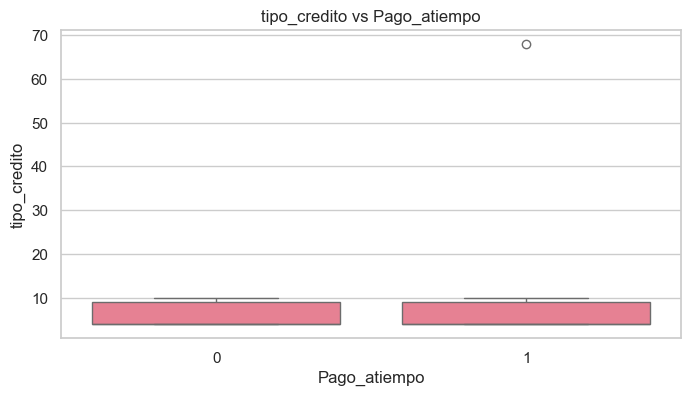

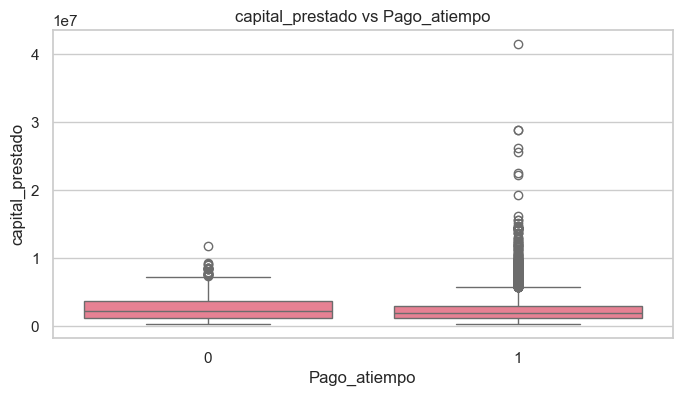

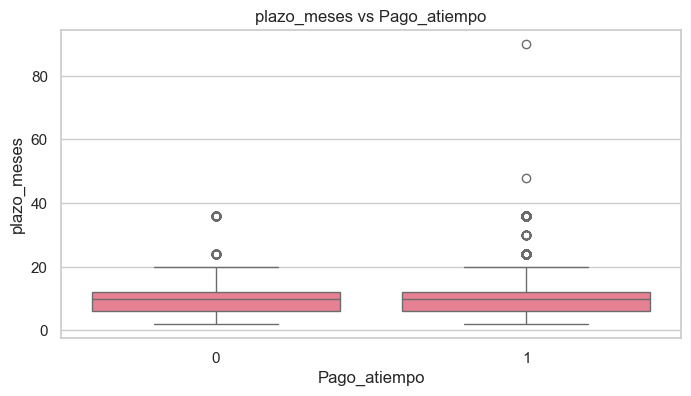

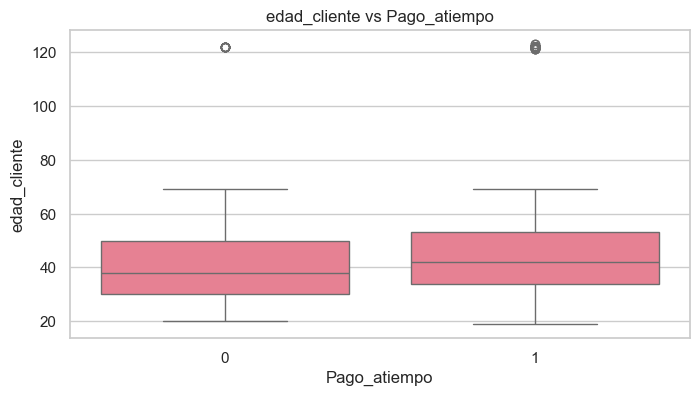

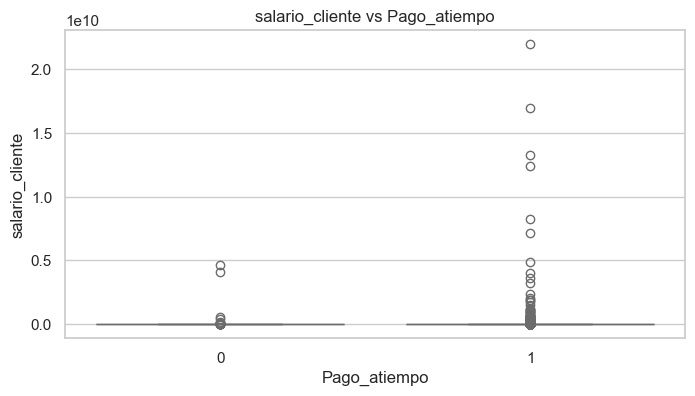

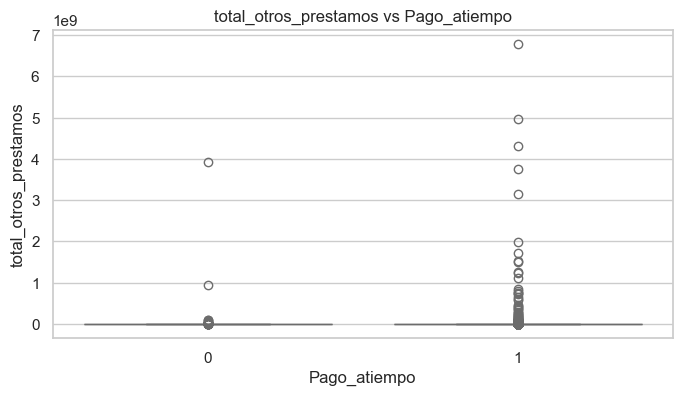

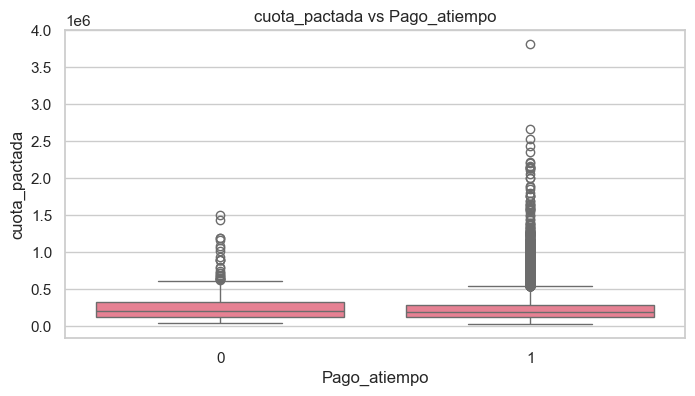

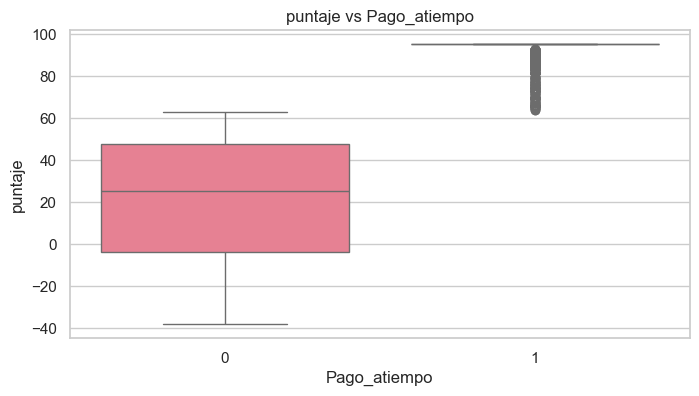

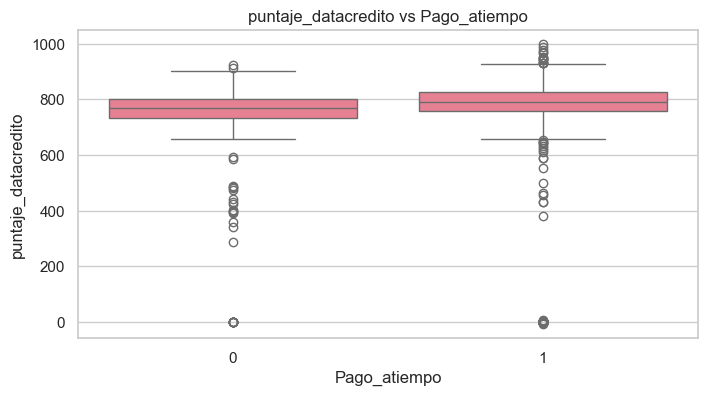

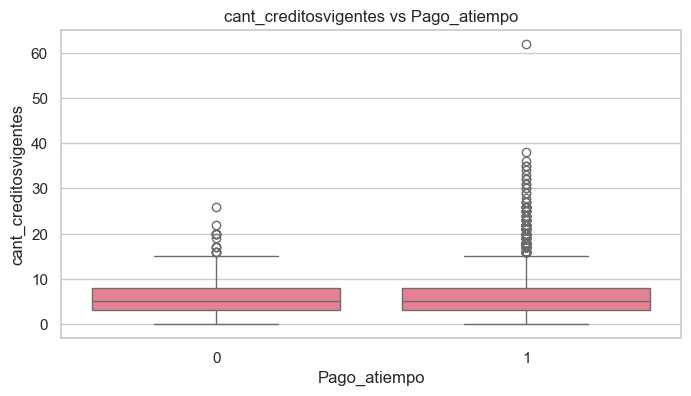

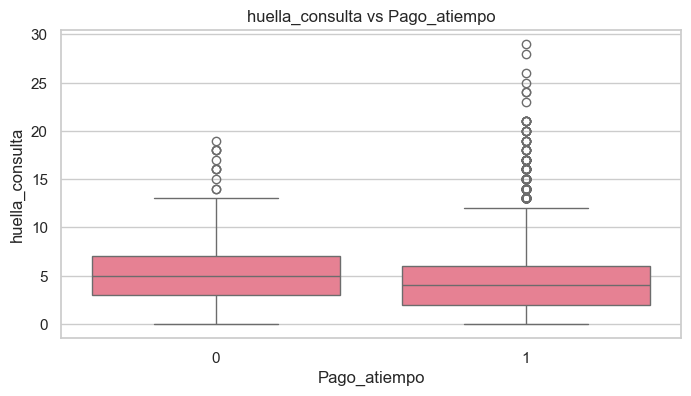

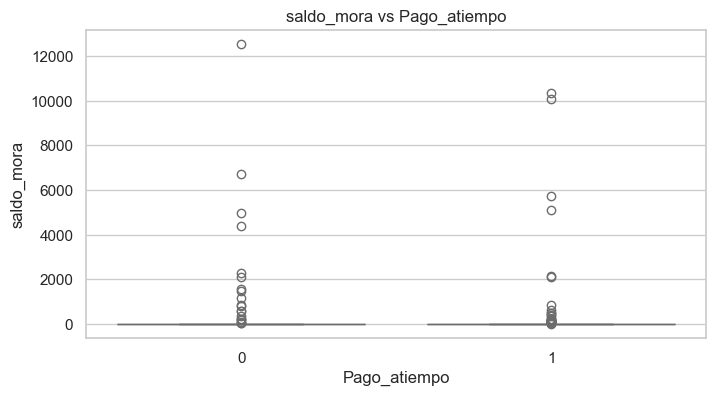

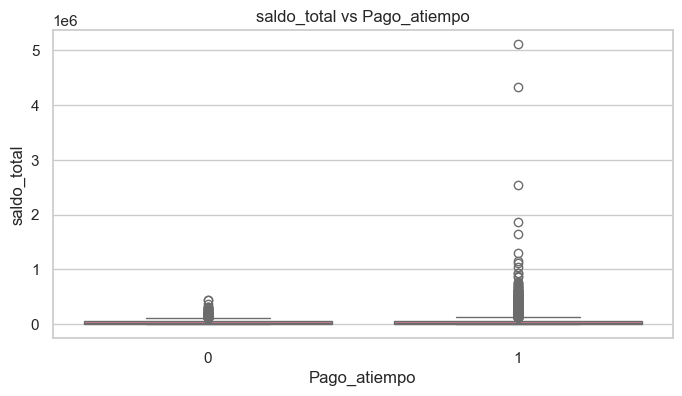

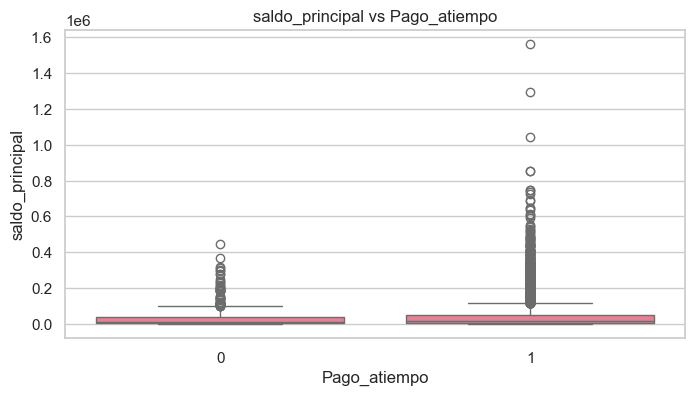

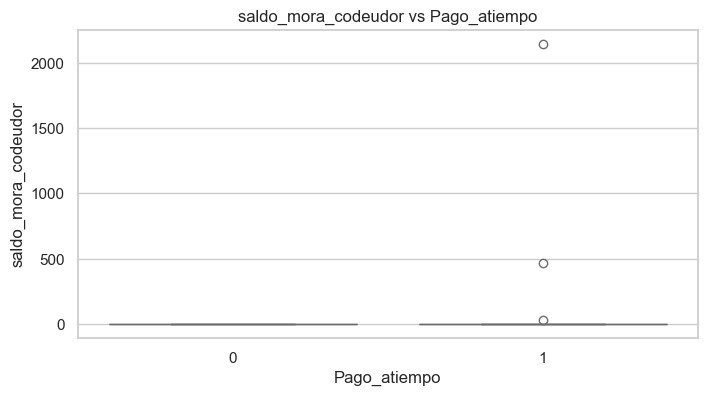

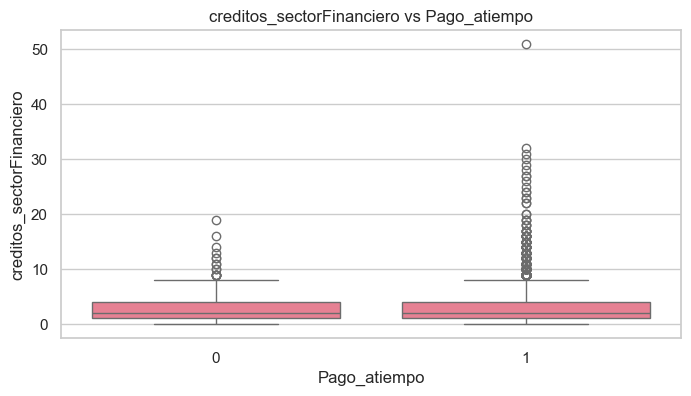

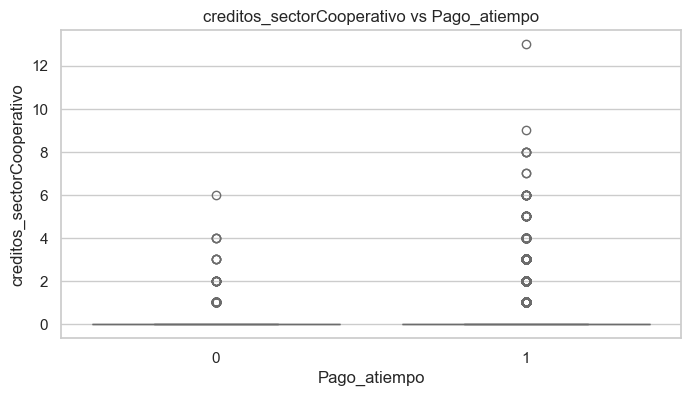

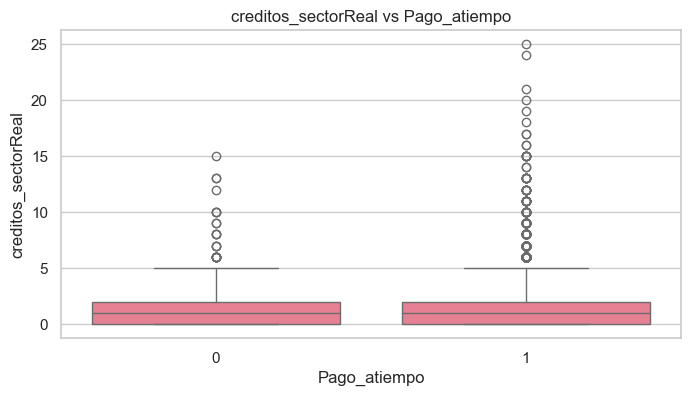

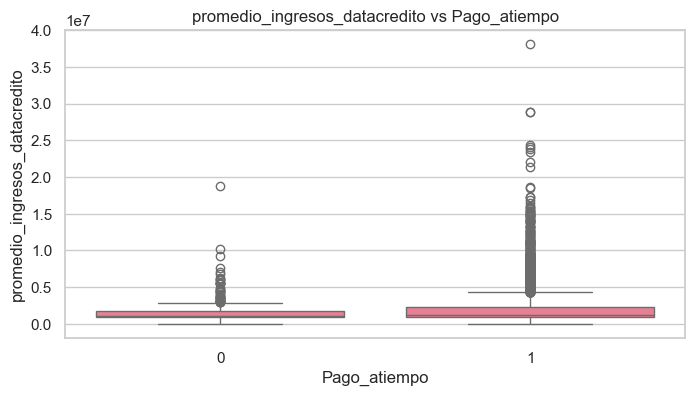

In [36]:
target = 'Pago_atiempo'

# Correlación
if len(col_num) > 1:
    plt.figure(figsize=(12, 10))
    corr = df[col_num].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación')
    plt.show()

# Relación con Target
if target in df.columns:
    print(f"CORRELACIÓN CON {target.upper()}:")
    print(df[col_num].corrwith(df[target]).sort_values(ascending=False))

    # Boxplots por target
    for col in col_num:
        if col == target: continue
        if 'id' in col.lower(): continue
        
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=target, y=col, data=df)
        plt.title(f'{col} vs {target}')
        plt.show()

## 10. Análisis Multivariado (Pairplot)

Visualización de relaciones entre pares de variables numéricas para identificar patrones conjuntos.

In [ ]:
# Análisis Multivariado
print("="*80)
print("ANÁLISIS MULTIVARIADO (PAIRPLOT)")
print("="*80)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar columnas numéricas relevantes
cols_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
vars_interes = [c for c in cols_numericas if df[c].nunique() > 2]

# Limitar variables si hay demasiadas para evitar gráficos ilegibles
if len(vars_interes) > 6:
    vars_interes = vars_interes[:6]
    print(f"Nota: Limitando visualización a las primeras {len(vars_interes)} variables numéricas.")

if len(vars_interes) > 1:
    plt.figure(figsize=(12, 12))
    if 'Pago_atiempo' in df.columns:
        # Crear copia para visualización
        df_viz = df.copy()
        df_viz['Estado_Pago'] = df_viz['Pago_atiempo'].map({0: 'No Pagó', 1: 'Pagó'})
        # Asegurar que no haya nulos en las columnas usadas
        cols_to_plot = vars_interes + ['Estado_Pago']
        df_plot = df_viz[cols_to_plot].dropna()
        
        pair_plot = sns.pairplot(df_plot, hue='Estado_Pago', palette='husl', corner=True)
        pair_plot.fig.suptitle('Pairplot de Variables Numéricas', y=1.02)
    else:
        pair_plot = sns.pairplot(df[vars_interes].dropna(), palette='husl', corner=True)
        pair_plot.fig.suptitle('Pairplot de Variables Numéricas', y=1.02)
    plt.show()
else:
    print("Insuficientes variables numéricas para pairplot.")
